<a href="https://colab.research.google.com/github/cartman12/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module4-databackedassertions/Mohamad%20Ali%20Nasser%20-%20LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=180.18849314523848, mobile=False), User(purchased=True, time_on_site=135.67700482149365, mobile=False), User(purchased=True, time_on_site=159.88535379510446, mobile=True), User(purchased=True, time_on_site=257.7835981679507, mobile=True), User(purchased=False, time_on_site=86.99445445027507, mobile=False), User(purchased=False, time_on_site=173.67358829592212, mobile=True), User(purchased=True, time_on_site=44.968058188901246, mobile=True), User(purchased=False, time_on_site=30.15219480121866, mobile=True), User(purchased=False, time_on_site=460.0007745853941, mobile=False), User(purchased=False, time_on_site=122.22911474525455, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,180.188493,False
1,True,135.677005,False
2,True,159.885354,True
3,True,257.783598,True
4,False,86.994454,False


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.395806383057993,5.457727420381445,6.012980358659168,6.370819673044487,6.526220869482321,6.618506115477453,6.744300972093091,6.937814523764514,7.022230321283178,7.738183255456649,...,570.7205763776294,572.579212329361,573.071762294419,577.5607756708825,578.0265919014007,578.8349054472059,584.0914381586123,586.960469433746,588.7975083689481,599.8083961016524
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,0,0,1,1
True,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,240,233,105,29,28
True,96,131,102,20,16


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,0.714286,0.64011,0.507246,0.591837,0.636364
True,0.285714,0.35989,0.492754,0.408163,0.363636


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.672,0.622667
True,0.328,0.377333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [0]:
import pandas as pd


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/cartman12/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')
print(df.shape)

(1200, 4)


In [5]:
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [0]:
# Remove / delete column in pandas dataframe

del df['Unnamed: 0']

In [7]:
df.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


In [9]:
df.dtypes

age              int64
weight           int64
exercise_time    int64
dtype: object

In [10]:
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [12]:
# I will theorise that both age and exercise_time play a role in determining weight
# First we are goining to take a look at the relationship between exercise time and weight then age and weight. With the weight as the depended varibale. 
# But we also have a third question is that does exercise_time go down with age?

# lets calculate the correlations first just to have a general idea

corr_e_w = df.exercise_time.corr(df.weight)

corr_a_w = df.age.corr(df.weight)

corr_e_a = df.exercise_time.corr(df.age)

corr_e_w, corr_a_w, corr_e_a



(-0.4780213304385566, 0.14416818571376627, -0.2738180438352109)

In [0]:
import matplotlib.pyplot as plt

In [0]:
plotscatter_a_e = plt.scatter(df.age, df.exercise_time)
plt.title('Exercise by Age')

plt.xlabel('Age')
plt.ylabel('Exercise time')

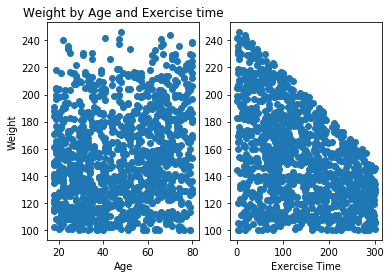

In [14]:
plt.subplot(1, 2, 1)
plt.scatter( df.age, df.weight)
plt.title('Weight by Age and Exercise time')
plt.ylabel('Weight')
plt.xlabel('Age')

plt.subplot(1, 2, 2)
plt.scatter( df.exercise_time, df.weight)

plt.xlabel('Exercise Time')

plt.show()

In [0]:
# The above plots indicate something that we need to investigate, we see a clear relationship between excersice time and weigght 
# but the relationship between age and weight is smoewhat spurious, while we do see a decrease in exercise time after the age of 60 but weight did not go up.

# I want to explore the data for those that are above 60 years, and see the different relationships

# Make a copy and then turn the age column into True for those that are aboce 60.
df2 = df.copy()
df2.age = df2['age'] > 60

In [16]:
df2.head()

,age,weight,exercise_time
0,False,118,192
1,False,161,35
2,False,128,220
3,False,216,57
4,False,116,182


In [0]:
# Create time bins for weight - I did not fully understand the error, but I understood that i needed to convert the type to <U32

time_bins_w = pd.cut(df2['weight'], 2).astype('<U32')

In [18]:
# Test the crosstab

pd.crosstab(df2.age, time_bins_w)

weight,"(173.0, 246.0]","(99.854, 173.0]"
age,,
False,206,617
True,143,234


In [0]:
# Create time bins for weight

time_bins_e = pd.cut(df2['exercise_time'], 2).astype('<U32')

In [20]:
# I chose to see two bins for each just to make things easier.

ct = pd.crosstab(df2.age, [time_bins_w, time_bins_e],
            rownames=['Above 60'], 
            colnames=["Weight", "Exercise_time"], 
            normalize='index')
ct

Weight        (173.0, 246.0]                (99.854, 173.0]               
Exercise_time  (-0.3, 150.0] (150.0, 300.0]   (-0.3, 150.0] (150.0, 300.0]
Above 60                                                                  
False               0.213852       0.036452        0.261239       0.488457
True                0.360743       0.018568        0.456233       0.164456

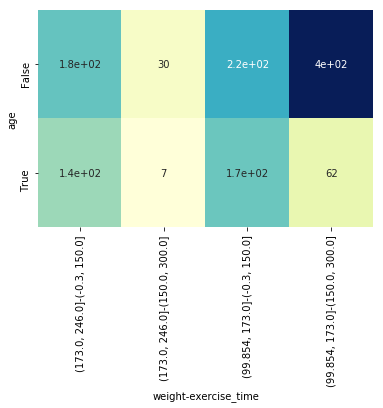

In [21]:
# using seabor to do a heatmap

import seaborn as sns
sns.heatmap(pd.crosstab(df2.age, [time_bins_w, time_bins_e] ),
            cmap="YlGnBu", annot=True, cbar=False);

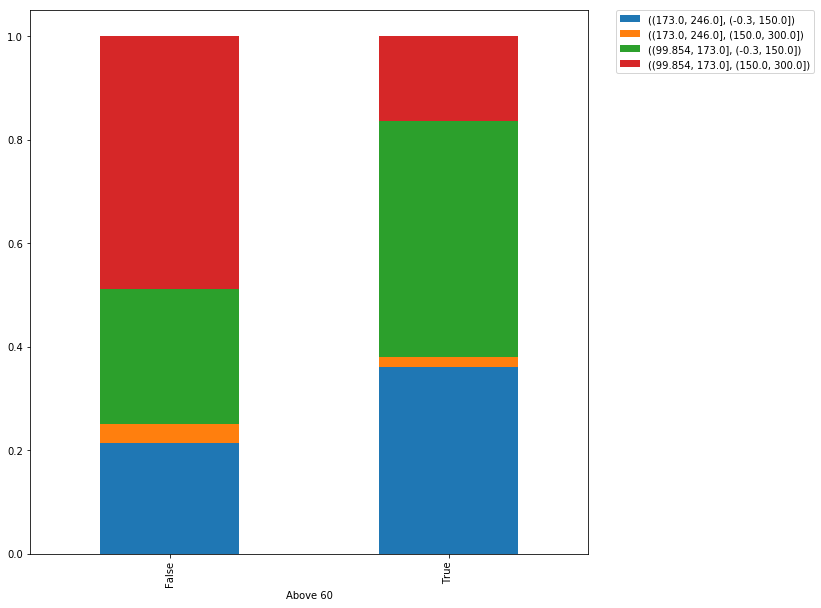

In [28]:
# Stacked bar using crossover data

ct.plot(kind='bar', stacked=True, figsize = (10,10))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # legend outised the box, thanks paul
plt.show()

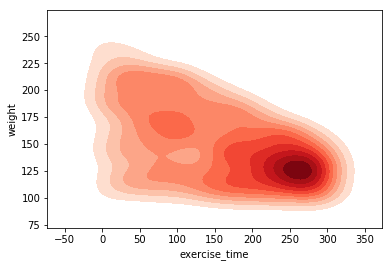

In [35]:
# Using kdeplot to drar a density graph to show people where people who are more than 60 or less than 60 are on the graph


blue = df.loc[df.age >= 60]
red = df.loc[df.age < 60]
ax = sns.kdeplot(red.exercise_time, red.weight,
                  cmap="Reds", shade=True, shade_lowest=False)

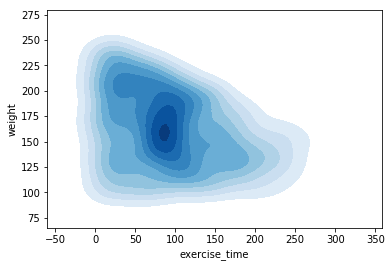

In [33]:
ax = sns.kdeplot(blue.exercise_time, blue.weight,
                 cmap="Blues", shade=True, shade_lowest=False)

In [0]:
# So the data does show that weight and age are not related, but people who are older than 60 tend to exercise less and have lower weight.

In [0]:
# My assumption is that the correlation that we have seen above is skewed because of the people above 60. So i will drop the people who are above 60 and calculate the correlation between exercise and weight.

In [0]:
# Removing all rows in which age is above 60

df3 = df.copy()
df3 = df3[df3.age < 60]

In [24]:
corr_e_w3 = df3.exercise_time.corr(df3.weight)
corr_e_w, corr_e_w3

(-0.4780213304385566, -0.509538370413645)

In [25]:
corr_e_a3 = df3.exercise_time.corr(df3.age)
corr_e_a, corr_e_a3

(-0.2738180438352109, 0.0547935806989091)

In [26]:
corr_a_w3 = df3.age.corr(df3.weight)
corr_a_w, corr_a_w3

(0.14416818571376627, 0.007841826762967982)

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)

In [0]:
# I was doing the stretch goal, and then I was drawn nto the Fifa kaggle, so I spent most of the time reading the kernels